<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MVPC" data-toc-modified-id="MVPC-1">MVPC</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-2">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-3">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-4">Visualize our data</a></span></li><li><span><a href="#Perform-group-level-analysis" data-toc-modified-id="Perform-group-level-analysis-5">Perform group-level analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# MVPC

# Create simulated dataset

In [21]:
## Code for simulating the data: ##
import pymc3 as pm
np.random.seed(1)
num_subjects = 20
num_conditions = 2
num_voxels = 50
num_trials = 10
num_runs = 4
data=[]

normal1 = pm.Normal.dist(mu=1.5,sigma=.5)
normal2 = pm.Normal.dist(mu=.5,sigma=.5)
unif = pm.Uniform.dist(lower=-3,upper=3)
cond1 = pm.Mixture.dist(w=[.2,.8], comp_dists=[normal1,unif])
cond2 = pm.Mixture.dist(w=[.2,.8], comp_dists=[normal2,unif])

activations=np.full(num_subjects*num_conditions*num_runs*num_trials*num_voxels,np.nan)
sub_id=np.full(num_subjects*num_conditions*num_runs*num_trials*num_voxels,np.nan)
cond_id=np.full(num_subjects*num_conditions*num_runs*num_trials*num_voxels,np.nan)
vox_id=np.full(num_subjects*num_conditions*num_runs*num_trials*num_voxels,np.nan)
run_id=np.full(num_subjects*num_conditions*num_runs*num_trials*num_voxels,np.nan)

cnt=0
for s in range(num_subjects):
    for c in range(num_conditions):
        for r in range(num_runs):
            for t in range(num_trials):
                for v in range(num_voxels):
                    if c==0:
                        activations[cnt]=cond1.random(size=1)
                    else:
                        activations[cnt]=cond2.random(size=1)
                    sub_id[cnt]=s
                    cond_id[cnt]=c
                    vox_id[cnt]=v
                    run_id[cnt]=r
                    trial_id[cnt]=t
                    cnt+=1

np.save('activations.npy',activations)
np.save('sub_id.npy',sub_id)
np.save('cond_id.npy',cond_id)
np.save('vox_id.npy',vox_id)
np.save('trial_id.npy',vox_id)
np.save('run_id.npy',run_id)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [30]:
# general packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn import svm

# pull data from GitHub
import requests, io
for array in ['activations','sub_id','cond_id','vox_id','run_id','trial_id']:
    globals()['{}'.format(array)] = np.load(io.BytesIO(requests.get(
        'http://paulscotti.github.io/navigateFMRI/methods/mvpa/{}.npy'.format(array)).content))

# overview of the data
num_subjects = len(np.unique(sub_id)) #20
num_conditions = len(np.unique(cond_id)) #2
num_voxels = len(np.unique(vox_id)) #50
num_runs = len(np.unique(run_id)) #4
num_trials = len(np.unique(trial_id)) #10

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [2]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Visualize our data

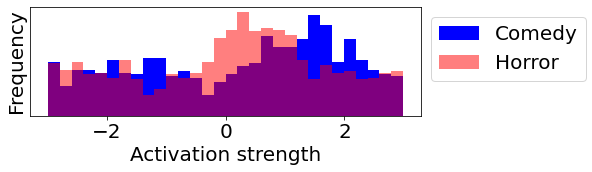

In [6]:
plt.hist(activations[cond_id==0],color='blue',bins=30,label='Comedy')
plt.hist(activations[cond_id==1],color='red',bins=30,alpha=.5,label='Horror')
plt.yticks([]);plt.ylabel('Frequency')
plt.xlabel("Activation strength")
plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig("2b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
plt.show()

In [ ]:
scores=[];
for s in range(num_subjects): #num_subjects
    model = svm.SVC(kernel='linear')
    # sort into training and test (samples,features)
    X_train = activations[(cond_id==0) & (sub_id==s)]
    X_train = X_train.reshape(num_runs//2*num_conditions,num_voxels)
    y_train = data[(data['run']%2==0)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['cond']].values
    y_train = y_train.reshape(num_runs//2*num_conditions,num_voxels)
    y_train = np.unique(y_train,axis=1)

    X_test = data[(data['run']%2==1)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['beta']].values
    X_test = X_test.reshape(num_runs//2*num_conditions,num_voxels)
    y_test = data[(data['run']%2==1)&(data['sub_num']==s)].sort_values(['cond','vox']).loc[:,['cond']].values
    y_test = y_test.reshape(num_runs//2*num_conditions,num_voxels)
    y_test = np.unique(y_test,axis=1)
    
    model.fit(X_train,y_train)
    scores = np.concatenate([scores,[model.score(X_test,y_test)]])
plt.scatter(np.arange(len(scores)),scores)
print("avg across subs:",np.mean(scores))

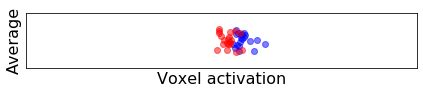

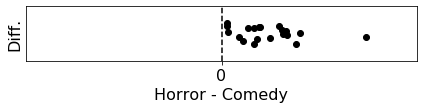

In [93]:
with plt.rc_context(rc={'font.size': 16, 'figure.figsize': (7,1)}):
    jitters = np.random.rand(num_subjects*2)/10
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='b',alpha=.5,label="Horror") 
    plt.scatter(data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[num_subjects:],color='r',alpha=.5,label="Comedy") 
    plt.ylabel('Average')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.savefig("2e.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean()-data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='k') 
    plt.xlabel('Horror - Comedy')
    plt.ylabel('Diff.')
    plt.axvline(0,color='k',linestyle='--')
    plt.yticks([])
    plt.xticks([0])
    plt.xlim([-1,1])
#     plt.title('Subject 19')
    plt.savefig("2f.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

# Perform group-level analysis

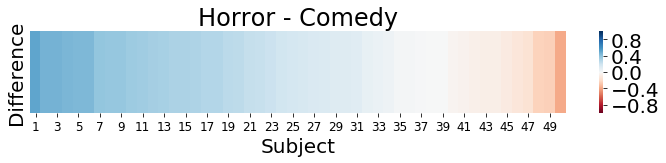

Horror vs. Comedy (paired t-test):
t=5.3904, p=0.0000, d=0.7623


In [110]:
# do statistics between conditions
a=np.mean(np.reshape(data[data['cond']==0]['beta'].values,(num_subjects,num_voxels)),
          axis=1) # averaging voxels (in condition 0) for every subject
b=np.mean(np.reshape(data[data['cond']==1]['beta'].values,(num_subjects,num_voxels)),
          axis=1) # averaging voxels (in condition 1) for every subject

with plt.rc_context(rc={'figure.figsize': (12,1.5)}):
    sns.heatmap(np.flip(np.sort([a-b])),vmin=-1,vmax=1,cmap="RdBu")
    plt.ylabel("Difference")
    plt.yticks([])
    plt.xticks(np.arange(.5,num_subjects+.5,2), np.arange(1,num_subjects,2), fontsize=12, rotation=0, ha="center")
    plt.xlabel("Subject")
    plt.title("Horror - Comedy")
    plt.savefig("3.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

stat = sp.stats.ttest_rel(a,b)
print("Horror vs. Comedy (paired t-test):\nt={:.4f}, p={:.4f}, d={:.4f}".format(
    stat.statistic,stat.pvalue,paired_cohen_d(a,b)))

# Conclusion

**ROI responded more to condition 0 (blue) than condition 1 (red)**